In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation_filter, simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn
from scipy.optimize import curve_fit

In [2]:
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [3]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
# psd_stamps = int(N_time / 2 + 1)
t = np.linspace(0, max_time, int(N_time))
gamma = 13e3
gain = 1.2e6

In [4]:
env = Particle(omega, gamma, radius=73e-9)

In [5]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base

In [6]:
def fit_psd(traces, delta_t):
    freq, power = psd(traces, delta_t)
    p0 =  [1e15, 2*np.pi*79000.0, 13e3, 0]
    ans, cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans


def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)
 

def generate_traces(env, gain, delta_t, N_time,  M, band_ranges):
    f_c = env.__omega__/(2*np.pi)
    cubic_delayed = {i: [None] for i in band_ranges}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        if key != 0:
            b, a = sn.butter(2, [f_c-key, f_c+key], fs=1/delta_t, btype='band', analog=False)
            for i in range(M):
                data = simulation_filter(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), a, b)
                data = np.array(data)
                cubic[i, :] = data
            cubic_delayed[key] = cubic
        else:
            for i in range(M):
                data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), 0)
                data = np.array(data)
                cubic[i, :] = data
            cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    return cubic_delayed

In [7]:
band_range = [0, 1e3, 5e4]
cubic_delayed = generate_traces(env, gain, delta_t, N_time, M, band_range)

-- Creating traces --


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:19<00:00,  6.61s/it]

-- Analysing and making PSD --


In [8]:
band_range = [0]
ref = generate_traces(env, 0, delta_t, N_time, M, band_range)

-- Creating traces --


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

-- Analysing and making PSD --


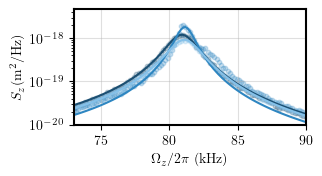

In [12]:
ax = plt.gca()
#fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
#fig.set_size_inches(3*1.3, 2.5, forward=True)
ax.figure.set_size_inches(3, 1.5, forward=True)
ax.grid(alpha = 0.4)
colors = ['#1B4F72', '#2E86C1', '#85C1E9']
labels = [r'$G_{fb}=\,$', r'$G_{fb} =\,$', r'$G_{fb}=\,$']
factors = [0.8768, 1, 0.86]
for i, key in enumerate(cubic_delayed.keys()):#gain, color, label, factor in zip(gains, colors, labels, factors):
    power, fitted_power, freq, _ = fit_psd(cubic_delayed[key], delta_t)
    ax.plot(freq/1000, fitted_power*env.zp_x**2, label=key, color=colors[i])#, color=color, label=label+str(float_gain)+r' $\times 10^6\textrm{N/m}{}^3$')
    ax.scatter(freq/1000, power*env.zp_x**2, alpha=0.25, s=10, color=colors[i])#, label='_{}'.format(label))
    ax.set_xlim([73, 90])
    ax.set_ylim([10**-20, 5*max(power*env.zp_x**2)])
    ax.set_yscale('log')
    ax.set(ylabel=r'$S_z(\textrm{m}{}^2$/Hz)')
    ax.set(xlabel=r'$\Omega_z/2\pi$ (kHz)')
#ax.legend()
plt.savefig('../plots/psds_filter.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
freq, power = psd(cubic_delayed[0], delta_t)


In [ ]:
p0 =  [1e15, 2*np.pi*79000.0, 13e3, 0]
ans, cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)


In [ ]:
plt.plot(np.linspace(0, 2*np.pi*10e4, freq.shape[0]), lorentzian(np.linspace(0, 2*np.pi*10e4, freq.shape[0]) , *ans))
plt.plot(freq, power)
plt.yscale('log')
plt.xlim([6e4, 1e5])

In [ ]:
plt.plot(freq, power)
plt.yscale('log')
plt.xlim([6e4, 10e4])

In [ ]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base


def fit_psd(traces, windows=20):
    freq, power = psd(traces, windows=windows)
    p0 =  [396360.1039417023, 79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans

In [ ]:
from multiprocessing import Pool
import numpy as np
from tqdm import tqdm
from scipy import signal as sn
from scipy.optimize import curve_fit
import csv
import matplotlib.pyplot as plt
import pdb
processes = 6
M = 60



radius = 75e-3                     # particle radius         micrometers
presure = 1e-3                     # gas pressure            kg/(micrometer*second^2)
m_gas = 2.325e-26                  # nitrogen gas molecule   kg
T = 300.0                            # temperature             Kelvin
kb = 1.38064852e-11                # Boltzmann cst.          picoJoule/Kelvin
v_gas = np.sqrt(3*kb*T/m_gas)      # meam squared velocity of nitrogen gas        micrometers/seconds
gamma = 15.8*radius**2*presure/(v_gas)
rho = 2200*1e-18                   # silica density          kilogram/(micrometers)^3
massa = rho*4*np.pi*radius**3/3    # mass                    kg
n_m = 1.01                         # medium refractive index
n_p = 1.46                         # particle refractive 
m = (n_p/n_m)                      # relative refractive  
NA = 0.7                           # numerical aperture
c = 3e14                           # speed of light          micrometers/seconds
P = 50e9                           # power                   kilogram*micrometers^2/seconds^3
wl0 = 0.78                         # laser wavelength        micrometers
wl_m = wl0/n_m                     # wavelength              micrometers
w0 = wl_m/(np.pi*NA)               # beam waist              micrometers
zr = np.pi*w0**2/wl_m              # railegh range           micrometers
I0 = 2*P/(np.pi*w0**2)             # intensity               Watts/meter^2
V0 = -(2*np.pi*n_m*radius**3/c)*((m**2-1)/(m**2+2))*I0 
                                   # potential depth         picoJoule 
#spring = -2*V0/(zr**2)             # spring constant         microNewtons/micometers
spring = 1.5348106e-6
print(spring)
t_relaxation = gamma/massa         # relaxation time         seconds
t_period =2*np.pi*np.sqrt(massa/spring)

dt = t_period/400                  # numerical integration with 400 points per period 
reduction = 50                    # one useful state point at avery few integration points
f_integration = 1/dt
f_sampling = f_integration/reduction
print(massa)
f_resonance = 1/t_period




x0 = np.sqrt(kb*T/spring)          # length scale
v0 = np.sqrt(kb*T*spring)/gamma
perturbation_ratio = 0.009
ratio = np.linspace(perturbation_ratio,perturbation_ratio,10)


def electric_force(z,perturbation_ratio):
    elec_number = 20.0
    elec_charge = 1.6e-19                        # electron charge
    # perturbation_ratio = 0.005
    charge = elec_number*elec_charge
    E0 = 2*spring*x0*perturbation_ratio/(charge)
    E = E0*(z/x0)**3
    return charge*E


def simulation(period_m=1000, force_on=0, feedback_filter=False, filter_dict={'order': 2, 'low': 99000, 'high': 101000}):
    max_time = period_m*t_period
    N_time = int(max_time/dt)          # size of simulation
    N_simulation = int(N_time/reduction)
    t = np.linspace(0,max_time,int(N_time/reduction))/t_period # time                    seconds

    # state = np.zeros(shape = (N_time,2))
    state = np.zeros(shape= (N_simulation,2))
    filtered_state = np.zeros(shape= (N_simulation,2))

    w = np.sqrt(2.0 * kb * gamma * T * dt ) * np.random.normal(size = N_time)/massa
    v = 0
    x = 0
    printcounter = 0
    b, a = sn.butter(filter_dict['order'], [filter_dict['low'], filter_dict['high']], fs=f_integration, btype='band', analog=False)
    x_window = np.zeros(b.shape)
    y_window = np.zeros((a.shape[0]-1))
    y_i = 0
    for k in range(N_time-1):
        x_window[1:] = x_window[:-1]
        x_window[0]  = x
        y_i = (b*x_window).sum()-(a[1:]*y_window).sum()
        y_window[1:] = y_window[:-1]
        y_window[0] = y_i

        if np.isnan(y_window).any():
            print(y_window, x_window)
            if np.isnan(y_window).all():
                break
        if feedback_filter:
            v = v - (gamma/massa)*v*dt -(spring/massa)*x*dt - force_on*electric_force(y_i,perturbation_ratio)*dt/massa +w[k] # Numerical integration of velocity    
        else:
            v = v - (gamma/massa)*v*dt -(spring/massa)*x*dt - force_on*electric_force(x,perturbation_ratio)*dt/massa +w[k] # Numerical integration of velocity
        x = x +v*dt                                                                                           # numerical integration of position
#        pdb.set_trace()

        
        if (printcounter == reduction):  # Storing less data than used to integrate.
            state[int(k/reduction),1] = v
            state[int(k/reduction),0] = x
            filtered_state[int(k/reduction),0] = y_i
            printcounter = 0
        printcounter += 1
    
    state[:,0] = state[:,0]
    
    return state[:,0], filtered_state[:,0], t



 
    

In [ ]:
omega = 2*np.pi*8e4
gamma = 13555
rho = 2200
particle_diameter = 0.143e-6 # m
particle_radius = particle_diameter/2
m = rho*4*np.pi*np.power(particle_radius,3)/3
m

In [ ]:
T0 = C*(2*omega)/(gamma*omega(gamma**2+omega**2))
T1 = 